In [1]:
import os
import numpy as np
import pandas as pd


import tensorflow as tf
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Bidirectional, SpatialDropout1D, Lambda, Activation
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from keras.optimizers import Adam

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc, RocCurveDisplay



import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix


In [ ]:
# Define defaults
FILENAME = "../../datasets/BCCC-CIC-IDS-2017/subsets/training_v1.csv"
FILENAME_TEST = "../../datasets/BCCC-CIC-IDS-2017/subsets/test_v1.csv"

In [3]:
# Load csv file
df = pd.read_csv(FILENAME, low_memory=False)
df_test = pd.read_csv(FILENAME_TEST, low_memory=False)

# Split X and y
X_train = df.drop("label", axis=1)
y_train = df["label"]

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]



In [4]:
# Normalize Training dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_features = X_train.columns.tolist()
X_train[top_features] = scaler.fit_transform(X_train[top_features])

In [5]:
attack_types = df['label'].unique()
attack_types

array([0, 3, 1, 5, 4, 2])

In [6]:
# Select attacks to exclude from training (simulate unseen attacks)
seen_attacks = attack_types[:int(len(attack_types) * 0.8)]
unseen_attacks = attack_types[int(len(attack_types) * 0.8):]

In [7]:
seen_attacks

array([0, 3, 1, 5])

In [8]:
unseen_attacks

array([4, 2])

In [9]:
X_train_seen = X_train[y_train.isin(seen_attacks)]
y_train_seen = y_train[y_train.isin(seen_attacks)]

In [10]:
# Further split test set to include unseen attacks
X_test_seen = X_test[y_test.isin(seen_attacks)]
y_test_seen = y_test[y_test.isin(seen_attacks)]
X_test_unseen = X_test[y_test.isin(unseen_attacks)]
y_test_unseen = y_test[y_test.isin(unseen_attacks)]

In [11]:
# convert to a bianry classification
y_train_seen = (y_train_seen != 0).astype(int)
y_test_unseen = (y_test_unseen != 0).astype(int)
y_test_seen = (y_test_seen != 0).astype(int)


In [12]:
y_train_seen.value_counts()


label
0    364830
1    191293
Name: count, dtype: int64

In [13]:
y_test_unseen.value_counts()


label
1    6602
Name: count, dtype: int64

In [14]:
y_test_seen.value_counts()

label
0    365427
1    190771
Name: count, dtype: int64

In [15]:
# Filter training data for seen attacks
# train_indices = y_train.isin(seen_attacks)
# X_train_seen = X_train[train_indices]
# y_train_seen = y_train[train_indices]

In [16]:
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
X_train_seen, y_train_seen = rus.fit_resample(X_train_seen, y_train_seen)

In [17]:
y_train_seen.value_counts()

label
0    191293
1    191293
Name: count, dtype: int64

In [18]:
# from gensim.models import KeyedVectors
# # Load GloVe (or use FastText)
# # You can download GloVe here: https://nlp.stanford.edu/projects/glove/
# glove_path = "/Users/alberto.llamas/Downloads/GloVeWord_Vectors/glove.6B.100d.txt"
# glove = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

# # Get attack class names
# attack_classes = ["Benign", "DoS_Hulk", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Slowhttptest", "DoS_Slowloris"]

# # Map to GloVe vectors
# class_embeddings = []
# for name in attack_classes:
#     vector = glove.get_vector(name.lower()) if name.lower() in glove else np.random.rand(100)
#     class_embeddings.append(vector)

# class_embeddings = np.stack(class_embeddings).astype(np.float32)


In [19]:
# #  Define Class Embeddings
# # Create one-hot embeddings
# num_classes = len(attack_types)
# class_embeddings = np.eye(num_classes).astype(np.float32)
# class_embeddings


In [20]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_upsampled, y_upsampled = smote.fit_resample(X_train, y_train)

# blnc_data = pd.DataFrame(X_upsampled)
# blnc_data['label'] = y_upsampled
# blnc_data = blnc_data.sample(frac=1)

# blnc_data['label'].value_counts()
# # X_train = blnc_data.drop("label", axis=1)
# # y_train = blnc_data["label"]

In [21]:
# sme = SMOTEENN(random_state=42, sampling_strategy='not minority')
# X_train, y_train = sme.fit_resample(X_train, y_train)
# X_val, y_val = sme.fit_resample(X_val, y_val)

In [22]:
# print('Resampled Train dataset shape %s' % Counter(y_train))
# print('Resampled Val dataset shape %s' % Counter(y_val))

In [23]:
# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)
# # X_val, y_val = rus.fit_resample(X_val, y_val)
# X_test, y_test = rus.fit_resample(X_test, y_test)

In [24]:
X_train_seen.shape

(382586, 108)

In [25]:
y_train_seen.shape

(382586,)

In [26]:
# from imblearn.under_sampling import AllKNN
# allknn = AllKNN()
# X_train, y_train = allknn.fit_resample(X_train, y_train)
# X_val, y_val = allknn.fit_resample(X_val, y_val)

In [27]:
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=42)
# X_train, y_train = cc.fit_resample(X_train, y_train)
# X_val, y_val = cc.fit_resample(X_val, y_val)

In [28]:

# ros = RandomOverSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = ros.fit_resample(X_train, y_train)
# X_val, y_val = ros.fit_resample(X_val, y_val)

In [29]:
# smt = SMOTETomek(random_state=42, sampling_strategy='auto')
# X_train, y_train = smt.fit_resample(X_train, y_train)
# X_val, y_val = smt.fit_resample(X_val, y_val)

In [30]:
# # Convert data into LSTM-friendly format
X_train_seen = X_train_seen.to_numpy().reshape((X_train_seen.shape[0], 1, X_train_seen.shape[1]))
# X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))
X_test_seen = X_test_seen.to_numpy().reshape((X_test_seen.shape[0], 1, X_test_seen.shape[1]))
X_test_unseen = X_test_unseen.to_numpy().reshape((X_test_unseen.shape[0], 1, X_test_unseen.shape[1]))


In [31]:
# # Convert data into LSTM-friendly format
# seq_length = 1  # Number of time steps per sequence

# # Train
# X_lstm, y_lstm = [], []

# for i in range(len(X_train) - seq_length):
#     X_lstm.append(X_train[i : i + seq_length])
#     y_lstm.append(y_train.iloc[i + seq_length])
    
# X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# X_train = X_lstm
# y_train = y_lstm

# # Val
# X_lstm, y_lstm = [], []

# for i in range(len(X_val) - seq_length):
#     X_lstm.append(X_val[i : i + seq_length])
#     y_lstm.append(y_val.iloc[i + seq_length])
    
# X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# X_val = X_lstm
# y_val = y_lstm

# # Test
# X_lstm, y_lstm = [], []

# for i in range(len(X_test) - seq_length):
#     X_lstm.append(X_test[i : i + seq_length])
#     y_lstm.append(y_test.iloc[i + seq_length])
    
# X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# X_test = X_lstm
# y_test = y_lstm


In [32]:
# Print the shapes of train and test sets
print(f"X_train seen shape: {X_train_seen.shape}")
print(f"X_test unseen shape: {X_test_seen.shape}")
# print(f"X_val shape: {X_val.shape}")

X_train seen shape: (382586, 1, 108)
X_test unseen shape: (556198, 1, 108)


In [33]:
print(f"X_test unseen shape: {X_test_unseen.shape}")

X_test unseen shape: (6602, 1, 108)


In [34]:
print(f"y_train seen shape: {y_train_seen.shape}")
print(f"y_test seen shape: {y_test_seen.shape}")
print(f"y_test unseen shape: {y_test_unseen.shape}")


y_train seen shape: (382586,)
y_test seen shape: (556198,)
y_test unseen shape: (6602,)


In [35]:
# Print label distribution in y_train and y_test
print("Label distribution in y_train seen:")
print(pd.Series(y_train_seen).value_counts())


Label distribution in y_train seen:
label
0    191293
1    191293
Name: count, dtype: int64


In [36]:
print("\nLabel distribution in y_test seen :")
print(pd.Series(y_test_seen).value_counts())


Label distribution in y_test seen :
label
0    365427
1    190771
Name: count, dtype: int64


In [37]:
print("\nLabel distribution in y_test unseen :")
print(pd.Series(y_test_unseen).value_counts())


Label distribution in y_test unseen :
label
1    6602
Name: count, dtype: int64


In [38]:
# print("\nLabel distribution in y_val:")
# print(pd.Series(y_val).value_counts())

In [39]:
# # Convert y_train, y_test and y_val to MultiLabel binaries
# mlb = MultiLabelBinarizer(classes=range(6))  # Specify the classes if needed (in this case, 6 labels)
# y_train_binary = mlb.fit_transform(y_train.reshape(-1, 1))
# y_test_binary = mlb.fit_transform(y_test.reshape(-1, 1))
# y_val_binary = mlb.fit_transform(y_val.reshape(-1, 1))

In [40]:
mlb = MultiLabelBinarizer(classes=range(6))  # Specify the classes if needed (in this case, 6 labels)

y_train_seen_binary = mlb.fit_transform(y_train_seen.to_numpy().reshape(-1, 1))
y_test_binary = mlb.fit_transform(y_test.to_numpy().reshape(-1, 1))
y_test_seen_binary = mlb.fit_transform(y_test_seen.to_numpy().reshape(-1, 1))
y_test_unseen_binary = mlb.fit_transform(y_test_unseen.to_numpy().reshape(-1, 1))
# y_val_binary = mlb.fit_transform(y_val.to_numpy().reshape(-1, 1))

In [41]:
# # Cosine similarity function
# def cosine_similarity(x):
#     x_norm = tf.nn.l2_normalize(x, axis=-1)
#     y_norm = tf.nn.l2_normalize(class_embeddings, axis=-1)

#     return tf.matmul(x_norm, y_norm, transpose_b=True)  # [batch_size, num_classes]

In [42]:
# embedding_dim = class_embeddings.shape[1]
# embedding_dim

In [43]:

# Build the LSTM Model
model = Sequential([
Input(shape=(1, 108)),  # Now (timesteps=1, features)
LSTM(256, return_sequences=True),
Dropout(0.2),
LSTM(128, return_sequences=True),
Dropout(0.2),
LSTM(64, return_sequences=False),  # No return_sequences in last LSTM
Dropout(0.2),
Dense(32, activation="relu"),
Dropout(0.2),
Dense(6, activation="softmax")
])


In [44]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       373,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,566 (2.37 MB)

 Trainable params: 622,566 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])


In [46]:
X_train_seen.shape

(382586, 1, 108)

In [47]:
# Fix shape before training
# X_train_seen = X_train_seen.to_numpy().reshape((X_train_seen.shape[0], 1, X_train_seen.shape[1]))
# X_train_seen.shape
# y_train_seen_binary = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [48]:
X_train_seen.shape

(382586, 1, 108)

In [49]:
print("y_train shape:", y_train_seen.shape)
print("First label sample:", y_train_seen_binary[0])


y_train shape: (382586,)
First label sample: [1 0 0 0 0 0]


In [50]:
# history = model.fit(X_train_seen, y_train_seen_binary, epochs=2, batch_size=32)
# history = model.fit(X_train_seen, y_train_seen_binary, epochs=10, batch_size=32)
history = model.fit(X_train_seen, y_train_seen_binary, epochs=10, batch_size=32)

Epoch 1/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - accuracy: 0.9121 - loss: 0.2041
Epoch 2/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9321 - loss: 0.1463
Epoch 3/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9320 - loss: 0.1441
Epoch 4/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9324 - loss: 0.1422
Epoch 5/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9328 - loss: 0.1419
Epoch 6/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9327 - loss: 0.1412
Epoch 7/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.9329 - loss: 0.1412
Epoch 8/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9332 - loss: 0.1408
Epoch 9/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9328 - loss: 0.1411
Epoch 10/10
11956/11956 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9334 - loss: 0.1398


In [51]:
# Evaluate on seen attacks
loss_seen, acc_seen = model.evaluate(X_test_seen, y_test_seen_binary)
print(f'Seen Attacks - Loss: {loss_seen}, Accuracy: {acc_seen}')

17382/17382 ━━━━━━━━━━━━━━━━━━━━ 15s 839us/step - accuracy: 0.9115 - loss: 0.1506
Seen Attacks - Loss: 0.15057824552059174, Accuracy: 0.9116268157958984


In [52]:
y_pred_probs = model.predict(X_test_seen)  # shape: (num_samples, num_classes)
y_pred = y_pred_probs.argmax(axis=1)       # get predicted class index
y_true = y_test_seen.to_numpy() if hasattr(y_test_seen, 'to_numpy') else y_test_seen


17382/17382 ━━━━━━━━━━━━━━━━━━━━ 13s 762us/step


In [53]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.87      0.93    365427
           1       0.80      1.00      0.89    190771

    accuracy                           0.91    556198
   macro avg       0.90      0.93      0.91    556198
weighted avg       0.93      0.91      0.91    556198



In [54]:
# Evaluate on unseen attacks
loss, acc = model.evaluate(X_test_unseen, y_test_unseen_binary)
print(f'Unseen Attacks - Loss: {loss}, Accuracy: {acc}')

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.5543 - loss: 4.9755
Unseen Attacks - Loss: 4.97484016418457, Accuracy: 0.5592244863510132


In [55]:
y_pred_probs = model.predict(X_test_unseen)  # shape: (num_samples, num_classes)
y_pred = y_pred_probs.argmax(axis=1)       # get predicted class index
y_true = y_test_unseen.to_numpy() if hasattr(y_test_unseen, 'to_numpy') else y_test_unseen

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


In [56]:
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     1.0000    0.5592    0.7173      6602

    accuracy                         0.5592      6602
   macro avg     0.5000    0.2796    0.3587      6602
weighted avg     1.0000    0.5592    0.7173      6602



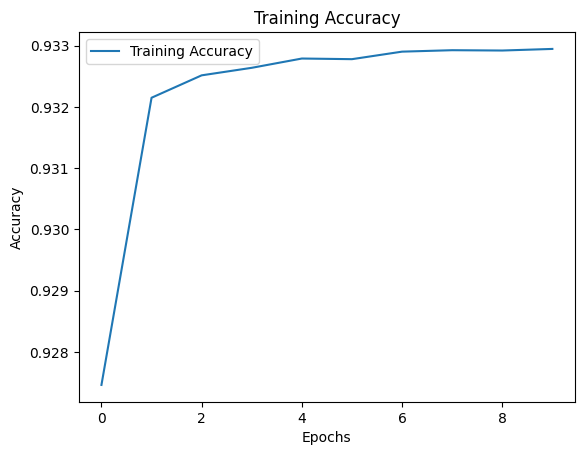

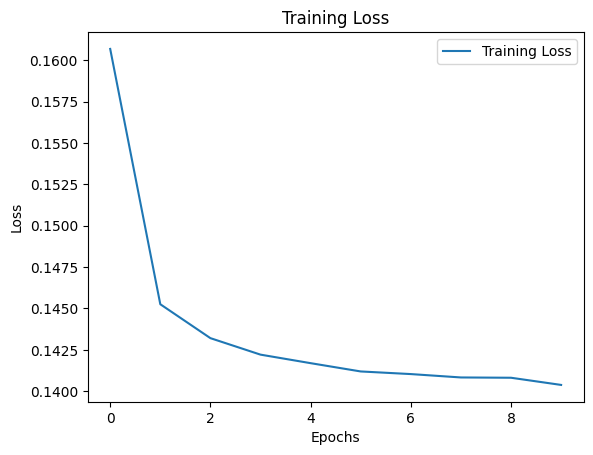

In [57]:
# Plot loss and accuraccy of training
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

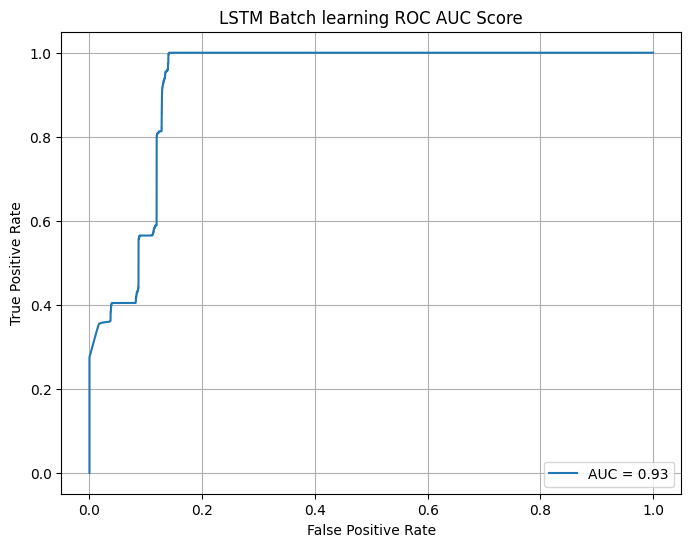

In [58]:
# Compute micro-average ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_unseen_binary.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')

# Plot random classifier
# plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Batch learning ROC AUC Score')
plt.legend()
plt.grid()
plt.show()

/var/folders/qg/czgp8gyn3057jghb1vm_44yr0000gp/T/ipykernel_84971/265180166.py:8: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100


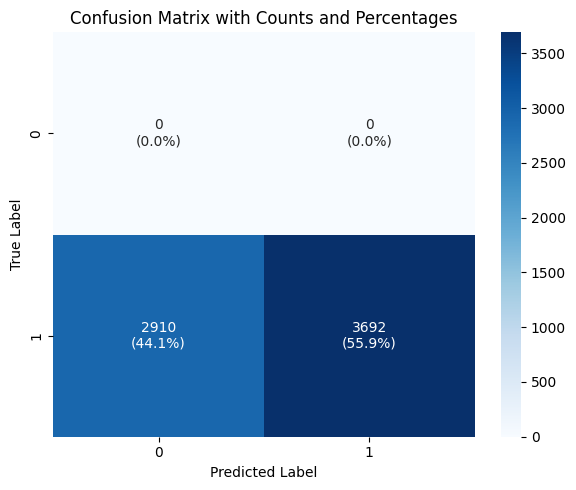

In [59]:
# Create annotations combining count and percentage
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero if any


# Create annotations combining count and percentage
annotations = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annotations[i, j] = f'{count}\n({percent:.1f}%)'

# Plot heatmap with both count and percentage
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix with Counts and Percentages')

plt.tight_layout()
plt.show()

